  0%|          | 0/5 [00:00<?, ?it/s]

Epoch[1/5], Train Loss: 18421.5307, Val Loss: 12618.9786


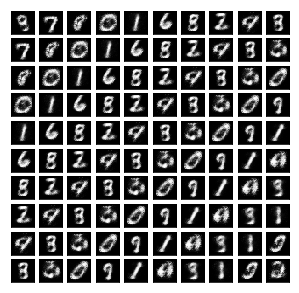

 20%|██        | 1/5 [00:05<00:20,  5.00s/it]

Epoch[2/5], Train Loss: 11134.4720, Val Loss: 9908.0103


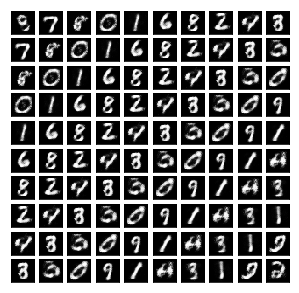

 40%|████      | 2/5 [00:10<00:15,  5.21s/it]

Epoch[3/5], Train Loss: 9156.1058, Val Loss: 8459.5323


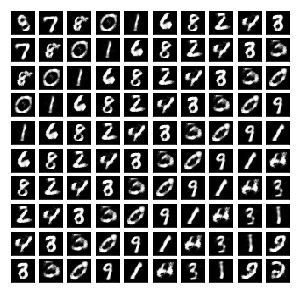

 60%|██████    | 3/5 [00:15<00:10,  5.26s/it]

Epoch[4/5], Train Loss: 8065.0661, Val Loss: 7781.2171


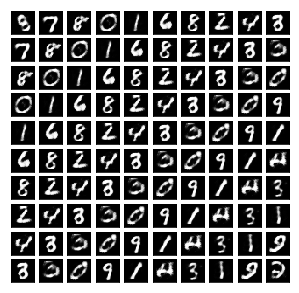

 80%|████████  | 4/5 [00:21<00:05,  5.41s/it]

Epoch[5/5], Train Loss: 7559.0374, Val Loss: 7433.1692


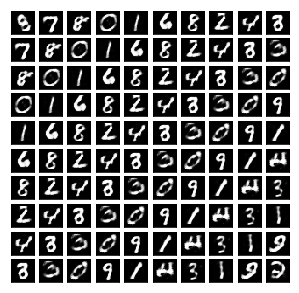

100%|██████████| 5/5 [00:27<00:00,  5.41s/it]


In [1]:
import os, sys
sys.path.append(os.path.abspath(os.path.join('../src/')))
from ae import *

# Enable Jupyter notebook plotting
%matplotlib inline

# Load in binzarized MNIST data, separate into data loaders
train_iter, val_iter, test_iter = get_data()

# Init model
model = Autoencoder(image_size=784,
                    hidden_dim=32)

# Init trainer
trainer = AutoencoderTrainer(model=model,
                             train_iter=train_iter,
                             val_iter=val_iter,
                             test_iter=test_iter,
                             viz=True)

# Train
trainer.train(num_epochs=5,
              lr=1e-3,
              weight_decay=1e-5)